In [2]:
import numpy as np
import pandas as pd

crsp = pd.read_csv("CRSP.csv")

/tmp/ipykernel_56345/3857759870.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp = pd.read_csv("CRSP.csv")


In [3]:
crsp["RET"] = crsp["RET"].replace("C", np.nan).replace("B", np.nan).astype(float)
crsp = crsp.dropna(subset=["TICKER", "PRC"])

crsp["VOL"] = crsp["VOL"].fillna(0)
crsp["DVOL"] = crsp["VOL"] * crsp["PRC"]
crsp["MarketCap"] = crsp["PRC"].abs()  * crsp["SHROUT"] * (crsp["CFACSHR"] / crsp["CFACPR"])

crsp = crsp.loc[
    (crsp["SHRCD"].isin([10, 11, 12]))
]


In [4]:
rets = pd.pivot_table(
    crsp,
    values="RET",
    index="date",
    columns="PERMNO"
)
companies = crsp[crsp.date == "2000-01-03"].nlargest(500, "MarketCap").PERMNO

rets = rets[companies]

vol60 = rets.ewm(60).std() * np.sqrt(252) + 0.01

In [5]:
train = rets.loc[:"2010-01-01"].dropna(axis=1)
test = rets.loc["2010-01-01":]
vol60 = vol60[train.columns].iloc[60:]
train = train.iloc[60:]

test = test[train.columns]

In [6]:
from core.contional_estimator import DCCEstimator
from core.unconditional_estimator import SampleCov, QIS, LS, AO


qis = QIS(train.values, vol60.reindex_like(train).values)

C_qis = qis.estimate()
ls = LS(train.values, vol60.reindex_like(train).values, rho=0.3)
C_ls = ls.estimate()

In [7]:

S_total = train.values / vol60.reindex_like(train).values
ao = AO(train.values, vol60.reindex_like(train).values, 
              lookback_window=500,).fit(S_total, sampling=10)

C_ao = ao.estimate()



Fitting AO model...: 100%|██████████| 196/196 [00:14<00:00, 13.21it/s]


In [8]:
sample_cov = SampleCov(train.values, vol60.reindex_like(train).values)
C_sample = sample_cov.estimate()

In [9]:
vol_test = vol60.reindex(test.index)
vol_test = vol_test.dropna()

test_aligned = test.reindex(vol_test.index)

vol_test = vol_test.clip(lower=1e-6)

(test_aligned.shape, vol_test.shape)

((3774, 312), (3774, 312))

In [13]:
import numpy as np
import pandas as pd
from tqdm import tqdm


def run_gmv_backtest(
    estimator,
    returns_df: pd.DataFrame,
    vol_df: pd.DataFrame,
    ridge: float = 1e-6,
    annualization: int = 252,
    long_only: bool = False,
):
    """Run a DCC one-step update backtest and return GMV performance stats."""
    clean_returns = returns_df.fillna(0.0)

    n_assets = clean_returns.shape[1]
    portfolio_returns: list[float] = []
    turnover_series: list[float] = []
    gross_leverage_series: list[float] = []
    effective_n_series: list[float] = []
    prev_w = np.zeros(n_assets)
    has_prev_weights = False

    for i, date in enumerate(tqdm(returns_df.index)):
        if isinstance(estimator, DCCEstimator):
            estimator._step()
            D_t = np.diag(estimator.D[i])
            Sigma_t = D_t @ estimator.R_t @ D_t
            Sigma_t = 0.5 * (Sigma_t + Sigma_t.T) + np.eye(n_assets) * ridge

        elif isinstance(estimator, np.ndarray):
            Sigma_t = estimator


        returns_row = returns_df.iloc[i]
        available = returns_row.notna()
        if not np.any(available):
            portfolio_returns.append(np.nan)
            turnover_series.append(np.nan)
            gross_leverage_series.append(np.nan)
            effective_n_series.append(np.nan)
            continue

        idx = np.where(available)[0]
        Sigma_slice = Sigma_t[np.ix_(idx, idx)] + np.eye(len(idx)) * ridge
        inv_cov = np.linalg.pinv(Sigma_slice)
        ones_slice = np.ones(len(idx))
        w_slice = inv_cov @ ones_slice
        w_slice /= ones_slice @ w_slice

        if long_only:
            w_slice = np.clip(w_slice, 0.0, None)
            weight_sum = w_slice.sum()
            if weight_sum <= 0:
                w_slice = np.ones(len(idx)) / len(idx)
            else:
                w_slice /= weight_sum

        r_obs = returns_row.values[idx]
        portfolio_returns.append(float(r_obs @ w_slice))

        full_w = np.zeros(n_assets)
        full_w[idx] = w_slice
        gross_leverage_series.append(float(np.sum(np.abs(full_w))))
        weight_sq_sum = float(np.sum(full_w ** 2))
        effective_n_series.append(float(1.0 / weight_sq_sum) if weight_sq_sum > 0 else np.nan)
        if has_prev_weights:
            turnover_series.append(float(np.sum(np.abs(full_w - prev_w))))
        else:
            turnover_series.append(np.nan)
            has_prev_weights = True
        prev_w = full_w

    returns_series = pd.Series(portfolio_returns, index=returns_df.index, name="gmv_return").dropna()
    metrics = pd.DataFrame(
        {
            "turnover": turnover_series,
            "gross_leverage": gross_leverage_series,
            "effective_n_assets": effective_n_series,
        },
        index=returns_df.index,
    )
    metrics = metrics.loc[returns_series.index]

    cumulative = (1 + returns_series).cumprod()
    drawdown = cumulative / cumulative.cummax() - 1

    stats = pd.Series(
        {
            "mean_daily": returns_series.mean(),
            "vol_daily": returns_series.std(),
            "sharpe_ann": (returns_series.mean() / returns_series.std()) * np.sqrt(annualization)
            if returns_series.std() > 0
            else np.nan,
            "cumulative_return": cumulative.iloc[-1] - 1,
            "max_drawdown": drawdown.min(),
            "turnover_sum": float(np.nanmean(metrics["turnover"].values)),
            "gross_leverage_mean": metrics["gross_leverage"].mean(),
            "effective_n_assets_mean": metrics["effective_n_assets"].mean(),
        }
    )

    return returns_series, stats, metrics

In [ ]:
estimators = {
    "SampleCov": C_sample,
    "QIS": C_qis,
    "LS": C_ls,
    "AO": C_ao,
    "DCC_QIS": DCCEstimator(C_qis, test_aligned.fillna(0.0).values, vol_test.reindex_like(test_aligned).values, alpha=0.01, beta=0.98),
    "DCC_LS": DCCEstimator(C_ls, test_aligned.fillna(0.0).values, vol_test.reindex_like(test_aligned).values, alpha=0.01, beta=0.98),
    "DCC_AO": DCCEstimator(C_ao, test_aligned.fillna(0.0).values, vol_test.reindex_like(test_aligned).values, alpha=0.01, beta=0.98),
    "DCC_SampleCov": DCCEstimator(C_sample, test_aligned.fillna(0.0).values, vol_test.reindex_like(test_aligned).values, alpha=0.01, beta=0.98),
}

run_results = {
    name: run_gmv_backtest(
        estimator,
        test_aligned,
        vol_test,
        ridge=1e-6,
        annualization=252,
        long_only=False,
    )
    for name, estimator in estimators.items()
}

100%|██████████| 3774/3774 [01:51<00:00, 33.99it/s]


In [32]:
agg_results = pd.DataFrame(
    {
        name: result[1]
        for name, result in run_results.items()
    }
)


agg_results.index = (
    ["ME", "STD", "SR", "Return", "Drawdown", "Turnover", "GrossLev", "EffN"]
)

# to latex
print(agg_results.T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & ME & STD & SR & Return & Drawdown & Turnover & GrossLev & EffN \\
\midrule
SampleCov & 0.000548 & 0.011146 & 0.781124 & 5.258330 & -0.390795 & 0.000630 & 1.000000 & 99.909685 \\
QIS & 0.000537 & 0.011006 & 0.774053 & 5.021626 & -0.387534 & 0.000473 & 1.000000 & 92.460738 \\
LS & 0.000526 & 0.010872 & 0.767450 & 4.807136 & -0.385349 & 0.000433 & 1.000000 & 95.883031 \\
AO & 0.000592 & 0.011758 & 0.799201 & 6.181936 & -0.402037 & 0.001084 & 1.000000 & 102.415808 \\
DCC_QIS & 0.000447 & 0.008109 & 0.875222 & 3.771101 & -0.313300 & 0.074744 & 1.000000 & 63.405455 \\
DCC_LS & 0.000443 & 0.007868 & 0.893133 & 3.726157 & -0.306446 & 0.073167 & 1.000000 & 64.393930 \\
DCC_AO & 0.000462 & 0.008934 & 0.820832 & 3.913599 & -0.329578 & 0.085871 & 1.000000 & 62.344215 \\
DCC_SampleCov & 0.000451 & 0.008327 & 0.860070 & 3.811869 & -0.317968 & 0.077490 & 1.000000 & 63.978533 \\
\bottomrule
\end{tabular}



In [19]:
agg_results

,SampleCov,QIS,LS,AO,DCC_QIS,DCC_LS,DCC_AO,DCC_SampleCov
mean_daily,0.000548,0.000537,0.000526,0.000592,0.000447,0.000443,0.000462,0.000451
vol_daily,0.011146,0.011006,0.010872,0.011758,0.008109,0.007868,0.008934,0.008327
sharpe_ann,0.781124,0.774053,0.767450,0.799201,0.875222,0.893133,0.820832,0.860070
cumulative_return,5.258330,5.021626,4.807136,6.181936,3.771101,3.726157,3.913599,3.811869
max_drawdown,-0.390795,-0.387534,-0.385349,-0.402037,-0.313300,-0.306446,-0.329578,-0.317968
turnover_sum,0.000630,0.000473,0.000433,0.001084,0.074744,0.073167,0.085871,0.077490
gross_leverage_mean,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
effective_n_assets_mean,99.909685,92.460738,95.883031,102.415808,63.405455,64.393930,62.344215,63.978533


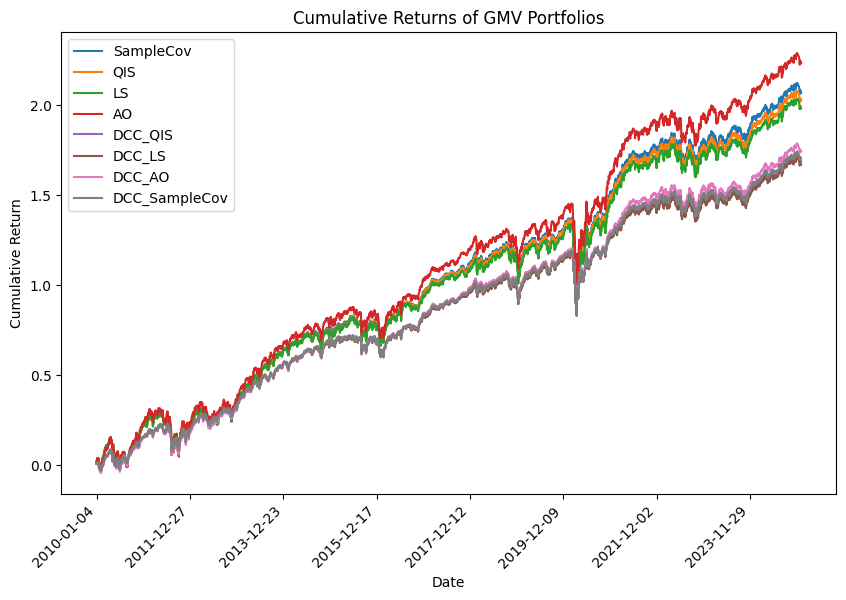

In [25]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 6))

for name, result in run_results.items():
    gmv_returns = result[0]
    gmv_returns.cumsum().plot(label=name, ax=ax)




plt.legend()
plt.title("Cumulative Returns of GMV Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")

plt.xticks(rotation=45, ha="right")

plt.show()



In [20]:
estimators = {
    "SampleCov": C_sample,
    "QIS": C_qis,
    "LS": C_ls,
    "AO": C_ao,
    "DCC_QIS": DCCEstimator(C_qis, test_aligned.fillna(0.0).values, vol_test.reindex_like(test_aligned).values, alpha=0.01, beta=0.98),
    "DCC_LS": DCCEstimator(C_ls, test_aligned.fillna(0.0).values, vol_test.reindex_like(test_aligned).values, alpha=0.01, beta=0.98),
    "DCC_AO": DCCEstimator(C_ao, test_aligned.fillna(0.0).values, vol_test.reindex_like(test_aligned).values, alpha=0.01, beta=0.98),
    "DCC_SampleCov": DCCEstimator(C_sample, test_aligned.fillna(0.0).values, vol_test.reindex_like(test_aligned).values, alpha=0.01, beta=0.98),
}


run_results_ls = {
    name: run_gmv_backtest(
        estimator,
        test_aligned,
        vol_test,
        ridge=1e-6,
        annualization=252,
        long_only=False,
    )
    for name, estimator in estimators.items()
}

100%|██████████| 3774/3774 [01:28<00:00, 42.44it/s]


In [33]:
agg_results_ls = pd.DataFrame(
    {
        name: result[1]
        for name, result in run_results_ls.items()
    }
)

agg_results_ls.index = (
    ["ME", "STD", "SR", "Return", "Drawdown", "Turnover", "GrossLev", "EffN"]
)

# to latex
print(agg_results_ls.T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & ME & STD & SR & Return & Drawdown & Turnover & GrossLev & EffN \\
\midrule
SampleCov & 0.000477 & 0.010610 & 0.713759 & 3.888445 & -0.315055 & 0.002821 & 4.349163 & 8.234838 \\
QIS & 0.000457 & 0.010392 & 0.698483 & 3.575675 & -0.319142 & 0.001781 & 3.777742 & 10.631438 \\
LS & 0.000454 & 0.009996 & 0.720325 & 3.582079 & -0.333852 & 0.001248 & 2.933567 & 17.668494 \\
AO & 0.000579 & 0.012913 & 0.711903 & 5.482530 & -0.398994 & 0.009329 & 8.155916 & 2.391476 \\
DCC_QIS & 0.000135 & 0.001522 & 1.412587 & 0.659802 & -0.037557 & 0.307653 & 3.814332 & 8.603517 \\
DCC_LS & 0.000159 & 0.001601 & 1.579359 & 0.815285 & -0.038311 & 0.270631 & 3.384960 & 10.803934 \\
DCC_AO & 0.000086 & 0.001334 & 1.022869 & 0.378452 & -0.031897 & 0.497708 & 5.486436 & 4.140736 \\
DCC_SampleCov & 0.000122 & 0.001456 & 1.326790 & 0.576637 & -0.035914 & 0.346738 & 4.168363 & 7.308186 \\
\bottomrule
\end{tabular}



In [24]:
agg_results_ls

,SampleCov,QIS,LS,AO,DCC_QIS,DCC_LS,DCC_AO,DCC_SampleCov
mean_daily,0.000477,0.000457,0.000454,0.000579,0.000135,0.000159,0.000086,0.000122
vol_daily,0.010610,0.010392,0.009996,0.012913,0.001522,0.001601,0.001334,0.001456
sharpe_ann,0.713759,0.698483,0.720325,0.711903,1.412587,1.579359,1.022869,1.326790
cumulative_return,3.888445,3.575675,3.582079,5.482530,0.659802,0.815285,0.378452,0.576637
max_drawdown,-0.315055,-0.319142,-0.333852,-0.398994,-0.037557,-0.038311,-0.031897,-0.035914
turnover_sum,0.002821,0.001781,0.001248,0.009329,0.307653,0.270631,0.497708,0.346738
gross_leverage_mean,4.349163,3.777742,2.933567,8.155916,3.814332,3.384960,5.486436,4.168363
effective_n_assets_mean,8.234838,10.631438,17.668494,2.391476,8.603517,10.803934,4.140736,7.308186


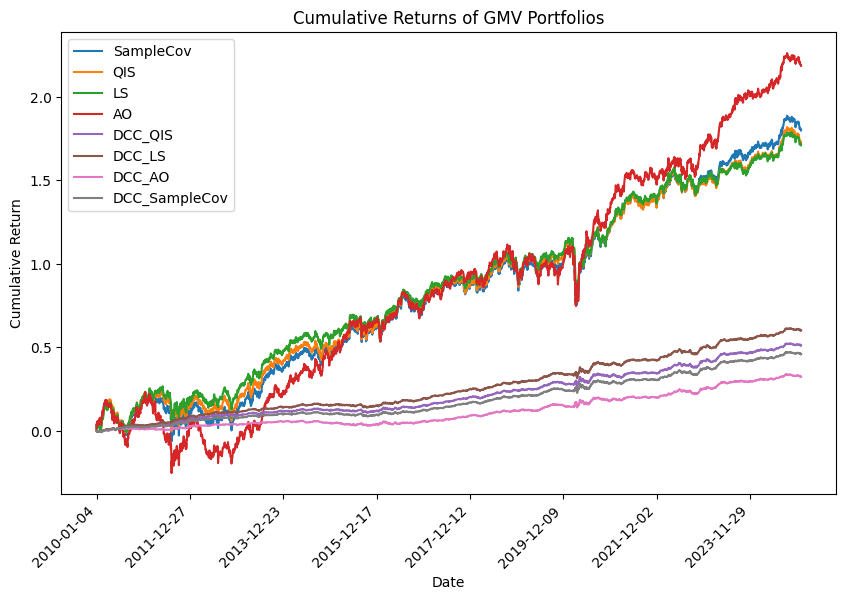

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 6))

for name, result in run_results_ls.items():
    gmv_returns = result[0]
    gmv_returns.cumsum().plot(label=name, ax=ax)




plt.legend()
plt.title("Cumulative Returns of GMV Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")






plt.xticks(rotation=45, ha="right")

plt.show()

